## Quantum simulation of the Schrödinger equation

<p>
<p>

The most general form of the Schrödinger equation is the time-dependent Schrödinger equation, which describes the wave function $\psi(\mathbf{r},t)$ of a quantum system, at time $t$ and position $\mathbf{r}$, for a given Hamiltonian $\hat{H}$:

$$i \hbar  \frac{\partial}{\partial t} \psi(\mathbf{r} , t) = \hat{H} \psi(\mathbf{r} , t)$$

The Hamiltonian can be interpreted as describing the total energy of the system. It contains a set of operations concerning all the interactions affecting the state of the system, and as a physical observable, it is self-adjoint. The time evolution is defined by the exponential of the Hamiltonian, which makes it a unitary operator, as per Stone’s theorem on one-parameter unitary groups. For a known wave function $\psi(\mathbf{r},0)$, the Schrödinger equation can provide knowledge about the wave function at an arbitrary time $t_{f}$, and allows for determination of outcome probability; $|\psi(\mathbf{r}, t_f)|^2$ is the probability of finding a quantum particle at a position $\mathbf{r}$ and time $t_f$.
    
Considering a one dimensional potential $V(x)$, a single particle of mass $m$ is governed by the Hamiltonian:

$$\hat{H} = \frac{\hbar^{2}\hat{k}^2}{2m} + V(x)$$

Where $\hbar$ is the reduced Planck constant, and $\hat{k}$ is the wave number of the particle.

**The general procedure for quantum simulation involves preparing an initial state $|\phi(0)\rangle$, finding the state $|\phi(t)\rangle$ of the quantum system at some time $t$ and computing the value of some physical quantity of interest.**

For a time independent Hamiltonian, $H$, the solution to the Schrödinger equation:
        
$$i\hbar\frac{d}{dt}|\phi\rangle=H|\phi\rangle$$


is given by $|\phi(t)\rangle=e^{-i\hbar H t} |\phi(0)\rangle$.

### Digital simulation - discretizing space

Admit a quantum system composed of a single particle. 

In the one-dimensional simplification, the motion of the system can be restricted to a region $-d \leq x \leq d$, which can be decomposed into $2^n$ intervals of length $\Delta x = \frac{2d}{2^n}$, such that it is possible to approximate the wave function over a discrete grid with points $x_m$, where $i \in [1, \, 2^{n}]$. 

Each point $x_m$, determined by the discretization of position, can be encoded in a state $|q_m\rangle$ using $n$ qubits such that $m \in [1, \, 2^{n}]$ and $|q_m\rangle = |q\rangle_{n-1}\otimes |q\rangle_{n-2}\otimes ...\otimes |q\rangle_0$. The wave function can then be expressed as:

$$ |\psi(x, t)\rangle = \frac{1}{N_F} \sum_{i = 1}^{2^n} \psi(x_m, t) |q_m\rangle$$

Where $N_F = \sqrt{\sum_{i=0}^{2^n} | \psi(x_m, t)|^2}$ acts as a normalization factor.

### Digital simulation - discretizing time


The time evolution operator over a step $\Delta t$ can be split into two steps using Trotter decomposition: $e^{-\frac{i}{\hbar}[H_0 + V(x)]\Delta t} \approx e^{-\frac{i}{\hbar}H_0 \Delta t} \, e^{-\frac{i}{\hbar}V(x) \Delta t}$. Admitting, for simplicity, $\hbar = m = 1$, the wave function for a point in space $x_1$ after a time step $\Delta t$ can then be determined as:

$$\psi(x_{i}, t + \Delta t) = e^{-i\hat{k}^2 \Delta t} \, e^{-i V(x_m)\Delta t} \, \psi(x_m , t)$$

Where $k$ is the wavenumber of the particle. In this approximation, the time evolution operator consists in alternating applications of the phase shift operator in the position and momentum representations. The Fourier transformation can be used to link these operators by first applying the direct Fourier transform, $F$, to get into the momentum representation, where $e^{-i\hat{k}^2 \Delta t }$ is diagonal. The inverse Fourier transform, $F^-1$, is then applied to return the system to the position representation, where $e^{-i V(x_m)\Delta t}$ is diagonal. The wave function at a time $l \Delta t$ is obtained by applying $l$ times the operator

$$F^{-1} \, e^{-i\hat{k}^2 \Delta t} \, F \, e^{-i V(x_m)\Delta t}$$

### Simulation algorithm

From this, the simulation of the Schrödinger equation on a quantum computer can be outlined into the following steps:

* Prepare the encoded initial state on the quantum computer, by applying the necessary transformations, $\hat{U}_{prep}$, over n qubits representing $N = 2^n$ points;
* Apply a diagonal phase transformation of the form $e^{-i V(x_m)\Delta t}$;
* Apply the Quantum Fourier Transform to change the system into momentum representation;
* Apply a diagonal phase transformation of the form $e^{-i\hat{k}^2 \Delta t}$;
* Apply the inverse QFT to return to the coordinate representation;
* Repeat steps (2) through (5) until an arbitrary time $l \Delta t$ is reached.

**TASK**: Follow the implementation for this algorithm available in section XVI of [this paper](https://arxiv.org/pdf/1804.03719.pdf), and check the results for different starting wave functions, and time steps.

In [1]:
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, compile

from qiskit.tools import visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram

from math import pi
import matplotlib.pyplot as plt

In [2]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=1000)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

In [3]:
def qftransform (circuit, qr, swap = True, n=0):
    if n == 0:
        n=qr.size
    for i in range(n-1, -1, -1):
        circuit.barrier()
        circuit.h(qr[i])
        for j in range (i-1, -1, -1):
            r = 2**(i-j+1)
            circuit.cu1((2*pi/r), qr[j], qr[i])
    circuit.barrier()
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])
            
def inverse_qftransform (circuit, qr, swap = True, n=0):
    if n == 0:
        n=qr.size
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])
    for i in range(0, n, 1):
        circuit.barrier()
        for j in range (0, i, 1):
            r = 2**(i-j+1)
            circuit.cu1((-2*pi/r), qr[i], qr[j])
        circuit.h(qr[i])
    circuit.barrier()

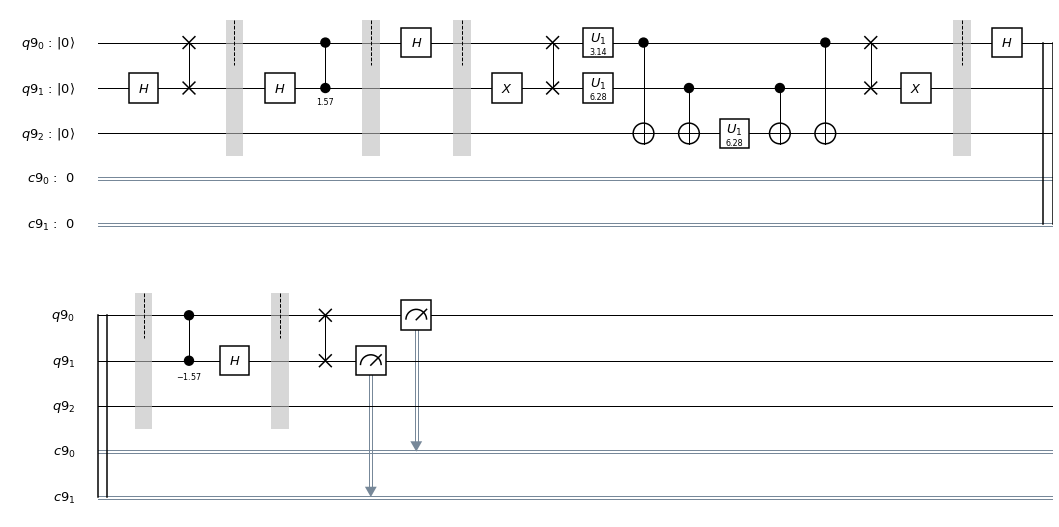

In [19]:
phi = pi

q = QuantumRegister(3)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

# State initialization
qc.h(q[1])

# QFT
qc.swap(q[0], q[1])
qftransform(qc, q, swap=False, n=2)
qc.x(q[1])
qc.swap(q[0], q[1])

# Phase-shift operations
qc.u1(phi, q[0])
qc.u1(2*phi, q[1])

qc.cx(q[0], q[2])
qc.cx(q[1], q[2])
qc.u1(2*phi, q[2])
qc.cx(q[1], q[2])
qc.cx(q[0], q[2])

# IQFT
qc.swap(q[0], q[1])
qc.x(q[1])
inverse_qftransform(qc, q, swap=False, n=2)
qc.swap(q[0], q[1])

qc.measure(q[0],c[0])
qc.measure(q[1],c[1])

qc.draw(output='mpl')



simulation: 

 {'01': 492, '11': 508}


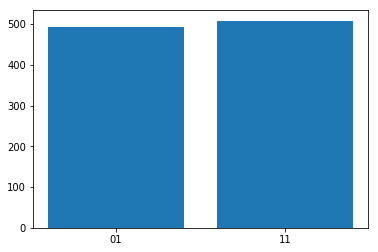

In [20]:
execute_locally(qc)